<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/Copy_of_chamferdistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


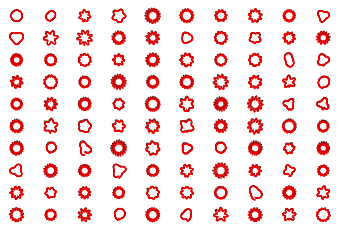

In [ ]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print(x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,x[l,:].type(torch.LongTensor),y[l,:].type(torch.LongTensor)]=1.0
        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[0,:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            pred = model(sample).view(1000,3)
            print('pred', pred.shape)
            predres = numpoints
            X = pred[:,0]
            Y = pred[:,1]
            
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            print("type",type(X))
            ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
            
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        z = torch.zeros(numpoints,1)
        #print(z.shape)
        points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.7") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [ ]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLPGEN(nn.Module):

    def __init__(self):
        super(MLPGEN, self).__init__()
        self.hidden_dim = 1*32*32
        self.featurevector = None
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, 3000),
            nn.Sigmoid()
        
        )
    

    def forward(self, x):
        #print(self.featurevector.shape)
        first = x.shape[0]
        x = x.reshape(first,-1)
        if x.shape != (first,self.hidden_dim):
            print('bad shape', x.shape)

        assert x.shape == (first,self.hidden_dim)
        return 32.0*self.mlp(x)

In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

dataset_train = DonutDataset(128*10)
dataset_val = DonutDataset(128*2)

mini_batch = 128
loader_train = data.DataLoader(
    dataset_train, batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset_train),
    num_workers=4)

loader_val = data.DataLoader(
    dataset_val, batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset_val),
    num_workers=4)

model = MLPGEN()


torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([256, 1]) torch.Size([256, 1]) torch.Size([256, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, betas=(0.5, 0.999), weight_decay=0.05)

for epoch in range(30):
  for x,y in loader_train:
    optimizer.zero_grad()
    predPoints = model(x)
    predPoints = predPoints.view(-1,1000,3)
    #print(predPoints.shape)
    y = y.reshape(predPoints.shape)
    assert predPoints.shape == (mini_batch,1000,3)
    assert y.shape == (mini_batch,1000,3)
    loss_chamfer, _ = chamfer_distance(predPoints, y)
    loss_chamfer.backward()
    optimizer.step()

    print(loss_chamfer)
  

tensor(5.0261, grad_fn=<AddBackward0>)
tensor(5.0578, grad_fn=<AddBackward0>)
tensor(5.4810, grad_fn=<AddBackward0>)
tensor(5.4076, grad_fn=<AddBackward0>)
tensor(5.3010, grad_fn=<AddBackward0>)
tensor(4.9770, grad_fn=<AddBackward0>)
tensor(5.2378, grad_fn=<AddBackward0>)
tensor(5.1490, grad_fn=<AddBackward0>)
tensor(4.8197, grad_fn=<AddBackward0>)
tensor(5.1336, grad_fn=<AddBackward0>)
tensor(5.1290, grad_fn=<AddBackward0>)
tensor(5.0167, grad_fn=<AddBackward0>)
tensor(5.5710, grad_fn=<AddBackward0>)
tensor(4.7810, grad_fn=<AddBackward0>)
tensor(5.5142, grad_fn=<AddBackward0>)
tensor(5.1156, grad_fn=<AddBackward0>)
tensor(5.0316, grad_fn=<AddBackward0>)
tensor(5.1692, grad_fn=<AddBackward0>)
tensor(5.1404, grad_fn=<AddBackward0>)
tensor(4.9930, grad_fn=<AddBackward0>)
tensor(5.0468, grad_fn=<AddBackward0>)
tensor(5.6965, grad_fn=<AddBackward0>)
tensor(5.7092, grad_fn=<AddBackward0>)
tensor(4.7415, grad_fn=<AddBackward0>)
tensor(5.2534, grad_fn=<AddBackward0>)
tensor(4.8141, grad_fn=<A

KeyboardInterrupt: ignored

In [ ]:
DonutDataset.displayCanvas('donut.png',dataset_val, model = model)

<IPython.core.display.Javascript object>

sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 3])
type <class 'torch.Tensor'>
sample torch.Size([1, 32, 32])
pred torch.Size([1000, 

<IPython.core.display.Javascript object>